# Kalorimetrie Küchentischversuch - Newtonsches Abkühlungsgesetz
Author: Pascal Pohlenz

Datum: 22.11.2023

Gruppe: 93

## Forschungsfrage


Kann das Newtonsche Abkühlungsgesetz mit 2 einfachen Sensoren bestätigt bzw. widerlegt werden und die bei Versuchen aufgenommenen Daten "FAIR" gespeichert werden ?

## Versuchsaufbau und Durchführung

<img src="figures/newton.jpg">
Es wird ein Gefäß mit einer heißen Flüssigkeit gefüllt und ein Temperatursensor in diese Flüssigkeit gegeben. Ein weiterer Temperatursensor befindet sich so im Raum, dass er die Umgebungstemperatur messen kann (Sensor wurde nach dem Bild händisch in der Luft gehalten). Daraufhin wird ein Programm gestartet, welches die beiden gemessenen Temperaturen zu definierten Zeitpunkten speichert. Nach ca. 10 Minuten wird die Aufzeichnung beendet und die erzeugten Messreihen mit den dazugehörigen Metadaten in eine hdf5-Datei gespeichert.

## Versuchsauswertung

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
# If you plan to write functions in another module,
# you can use importlib.reload(module) to reload the module
# at the beginning of each cell in order to make the latest
# changes take effect without restart the kernel.
import importlib
from functions import m_json
# Use FST-Style, if you don't like it, you can safely delete this line.
plt.style.use("FST.mplstyle")


### Newtonsches Abkühlungsgesetz

Hinweis: Nutzen Sie die Funktionen *get_ids_from_setup* und *get_json_entry* um auf Metadaten zuzugreifen. 

Sie sollten Ihr Programm zwischen TODO und DONE implementieren, und versuchen die Anweisung zu verfolgen. Das ist aber nicht erforderlich.


#### (i) Messdaten einlesen

Messdaten werden in das Notebook eingelesen.

In [45]:
hdf5_path = "data/data_newton.h5"

In [46]:
# Einlesen der Metadaten des Versuchsetups und einlesen der aufgezeichneten Temperaturen mit den zugehörigen Zeiten
ids = m_json.get_metadata_from_setup("data/newton/setup_newton.json")
with h5py.File(hdf5_path, 'r') as f:
    temp_hot_cup = np.array(f.get("RawData/1ee84919-ff67-68fc-a854-e2beea74d373/temperature"))
    time_hot_cup = np.array(f.get("RawData/1ee84919-ff67-68fc-a854-e2beea74d373/timestamp"))
    temp_environment = np.array(f.get("RawData/1ee8491a-b1f8-6a10-a247-4e56289ecc9a/temperature"))
    time_environment = np.array(f.get("RawData/1ee8491a-b1f8-6a10-a247-4e56289ecc9a/timestamp"))
    metadata = f.attrs
    metadata = {key: value for key, value in metadata.items()}
    print(metadata)

{'all': {'names': ['group_info',
                   'raspberry_pi',
                   'temperature_environment',
                   'temperature_cup',
                   'hot cup',
                   'probe_description',
                   'water heater',
                   'water'],
         'values': ['1ee84943-d884-6da0-9c3e-62cba276d436',
                    '1ee8493c-56b2-6175-a5c3-c779b519ae83',
                    '1ee8491a-b1f8-6a10-a247-4e56289ecc9a',
                    '1ee84919-ff67-68fc-a854-e2beea74d373',
                    '1ee87156-8688-6361-b3fd-101799b5c73c',
                    'xxxxxxxx-xxxx-xxxx-xxxx-xxxx(UUID)yy',
                    '1ee87158-8ea2-6750-8b7f-8a0ffc4f05a7',
                    '1ee8715b-f57f-674e-b1f7-00f660da53be']},
 'cup': {'names': ['hot cup'],
         'values': ['1ee87156-8688-6361-b3fd-101799b5c73c']},
 'group_info': {'names': ['group_info'],
                'values': ['1ee84943-d884-6da0-9c3e-62cba276d436']},
 'instrument': {'names': ['ra

#### (ii) Daten Semi–log ploten

Die Zeit und Differenz zwischen der heißen Flüssigkeit und der Umgebungstemperatur wird aufgezeichnet.

Die y-Achse (Temperaturdifferenz) ist auf logarithmisch eingestellt und die x-Achse (Zeit) verwendet eine normale Skalierung.

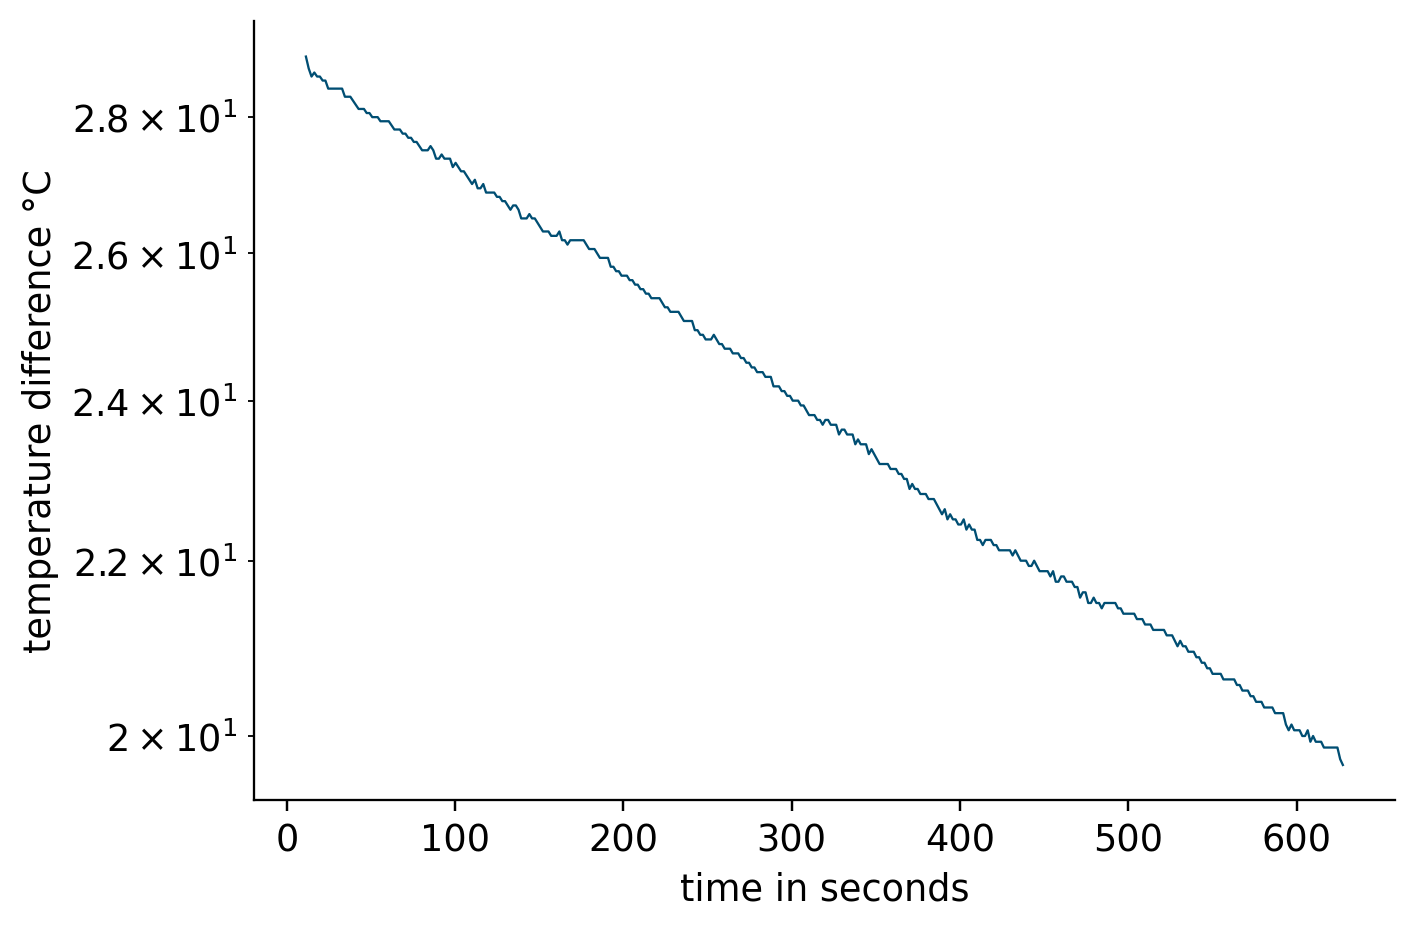

In [51]:
# Bilden der Temperaturdifferenz beider Sensoren und plotten ein Koordinatensystem mit logarithmischer y-Achse
temp_diff = temp_hot_cup - temp_environment
plt.yscale("log")
plt.plot(time_hot_cup, temp_diff)
plt.xlabel("time in seconds")
plt.ylabel("temperature difference °C")
plt.show()

#### (iii) Koeffizient in Newtonschem Abkühlungsgesetz
Die `numpy.polyfit` Funktion ist zu verwenden, um den Koeffizienten $K$ zu bestimmen.
$$
T(t) - T_2 = (T_1 - T_2)e^{Kt}
$$
Dabei ist $T(t) - T_2$ der Verlauf der Temperaturdifferenz. Die Anfangstemperatur ist $T_1$, die Endtemperatur ist $T_2$.

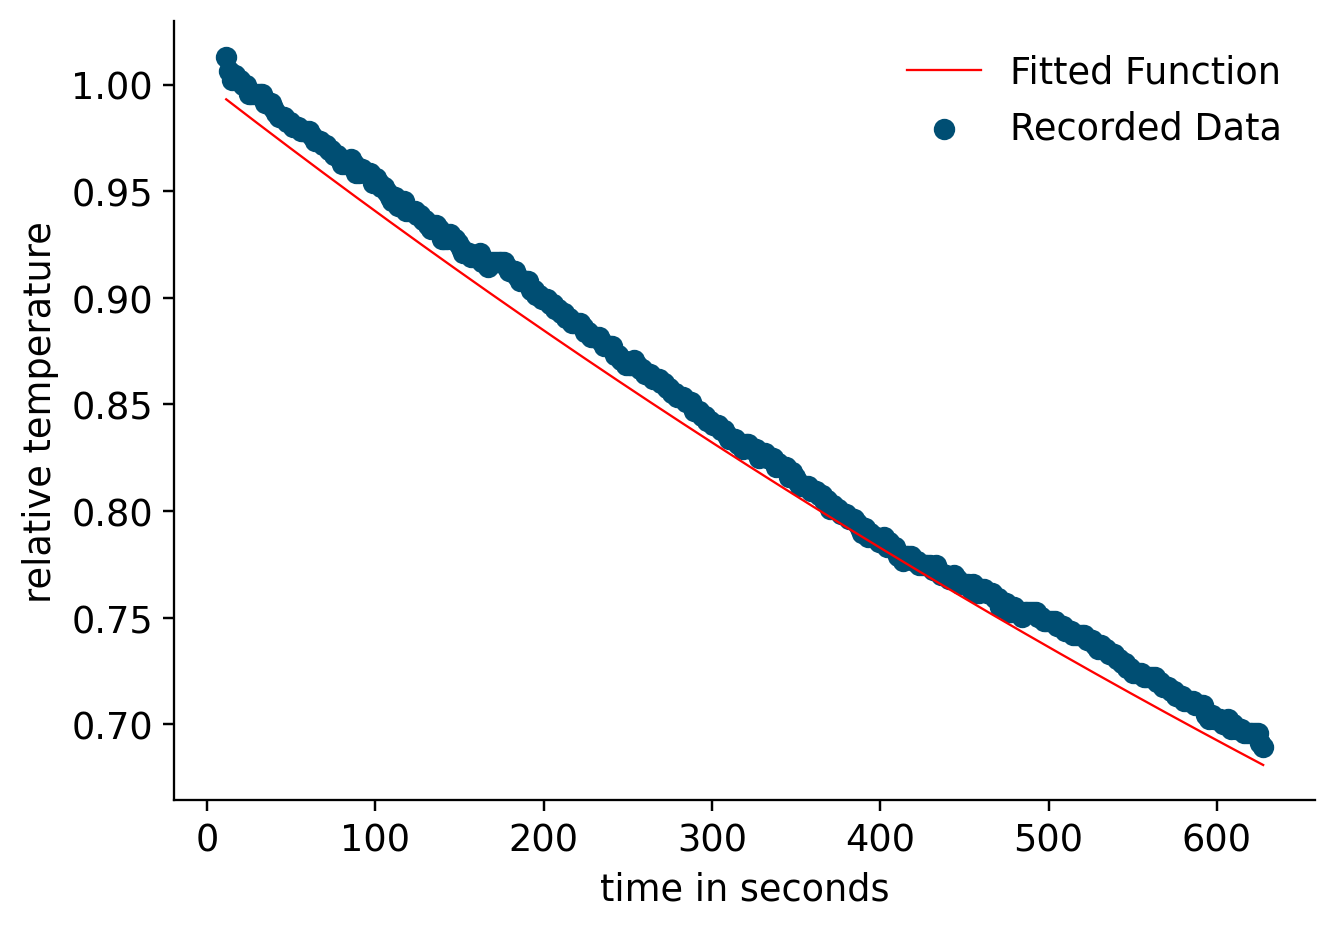

In [48]:
# Definieren der Anfangs-/ und Endtemperatur der Flüssigkeit
t_1 = temp_hot_cup[0]
t_2 = temp_environment[-1]
# Umstellen der Gleichung nach dem exponentiellen Term
e_kt= temp_diff/(t_1-t_2)
# Berechnung des Koeffizienten K mithilfe von np.polyfit
coefficients = np.polyfit(time_hot_cup, np.log(e_kt),1)
k = coefficients[0]
# Vergleich der gemessenen Zeitwerte mit den errechneten, gefitteten Exponentialfunktion in einem gemeinsamen Koordinatensystem
fitted_function = np.exp(k * time_hot_cup)
plt.scatter(time_hot_cup, e_kt, label='Recorded Data')
plt.plot(time_hot_cup, predicted_exp_term, label='Fitted Function', color='red')
plt.xlabel('time in seconds')
plt.ylabel('relative temperature')
plt.legend()
plt.show()
# DONE #

#### (iV) Ergebnis

In [49]:
# Ausgabe des berechneten Koeffizienten
print(f"Der Koeffizient K beträgt beträgt etwa : {k}")

Der Koeffizient K beträgt beträgt etwa : -0.0006123302592699023


## Diskussion

Das Newtonsche Abkühlungsgesetz kann in der Form, wie es auch im Skript steht, mit den Ergebnissen bestätigt werden. Man sieht dass es einen Faktor k einer Exponentialfunktion der Form e^(k*t) gibt, welche die aufgenommenen Temperaturen qualitativ "nachfährt". Es fällt auf, dass der Faktor k sehr klein ist, was zu einem nahezu linearen Verhalten bei kleinen Messungen mit geringer Zeit führt.

Zusätzlich wurden, wie auch bei dem Wärmekapazitätsversuch, die dabei genutzten bzw. erstellten Metadaten FAIR-erstellt und abgespeichert. Insbesondere dadurch, dass sie sowohl händisch als auch maschinell gelesen und bearbeitet werden können. 

## Fazit
Der Versuch hat wie der Wärmekapazitätsversuch zu einem tieferen Verständnis der Datenerstellung und Bearbeitung nach dem FAIR-Prinzip geführt. Ebenso wurden auch weitere Methoden erklärt mit Python und Thonny zu arbeiten.